In [31]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sc
import sklearn as sk
import sklearn.covariance as skc
import graph_helpers as gh

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# graphical lasso

On considère $n$ observations $x_{1},x_{2},\ldots ,x_{n}$. On s'interesse à l'estimation d'une matrice de précision $P = C^{-1}$. Si on fait l'hypothèse que les $x_i$ sont tirés aléatoirement suivant un va gaussienne $Z$, on espère que le C obtenu est une bonne estimation de la matrice de covariance de $Z$. 

Le graphical lasso résout
$$\operatorname {argmin} _{P \geq 0} \operatorname {tr} (S P )-\log \det(P )+\lambda \sum _{j\neq k}|P _{jk}|$$

où $S$ est la covariance des échantillons, et $\lambda$ est le paramètre de pénalisation.

Nous allons tester le graphical lasso sur les différentes formes de graphes synthétisés afin d'évaluer ses performances.

In [46]:
# on définit un graphe par sa matrice de précision
m = 16
a = -.2  # corrélation minimum 
name = "grilleCarree" #cyclique ou grilleCarree
A,Vx,Vy = gh.init_graph(name,m)

U = np.triu((1-a)*np.random.rand(m,m) + a)  # bruit balnc entre a et 1 
U=U+U.T    # Pour que Q soit symétrique
Q = A*U    # matrice de graphe pondéré
assert np.linalg.norm(Q-Q.T)<1e-6, "Q n'est pas symétrique !"

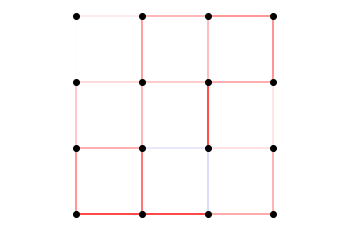

In [33]:
gh.dessin_graphe(Q,Vx,Vy)

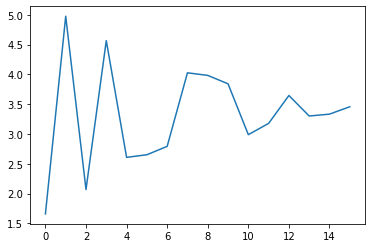

In [34]:
#Pour générer des vecteurs gaussiens de matrice l'inverse de Q, Q doit être inversible, 
#ce qui n'est pas forcément le cas. On modifie Q pour avoir des vp positives
L = np.linalg.eigvals(Q)
c = -2*np.min(L)
P0 = Q + c*np.eye(m) 
# il faudrait relier c à un kappa, paramètre permettant de jouer sur le conditionnement de P0 
L = np.linalg.eigvals(P0)
plt.plot(L)

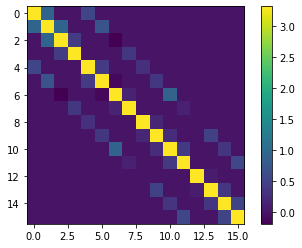

In [35]:
plt.imshow(P0)
plt.colorbar()

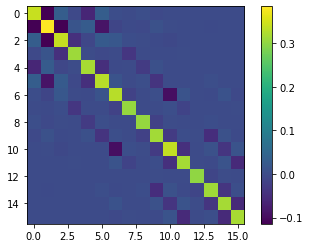

In [36]:
C0 = np.linalg.inv(P0)
plt.imshow(C0)
plt.colorbar()

Pour générer des vecteurs gaussiens de matrice de covariance $C_0$ : 

`w = randn(m,1)` réalisation d'un vecteur gaussien de moyenne nule et de covariance I_m ($E(ww^T) = I_{m\times m}$

Soit $A$ matrice telle que $Z = Aw$. On a Cov($Z$) = $E(ZZ^T) = AA^T = C_0$. On choisit $A = C_0^{\frac{1}{2}}$ car $C_0$ positive.

In [37]:
n = 100 # nombre d'échantillons
# on génére des va gaussiens de moyenne nulle et de matrice de covariance C0
X = (sc.linalg.sqrtm(C0)@np.random.randn(m,n)).T
#covariance empirique des échantillons
C = X.T@X/n

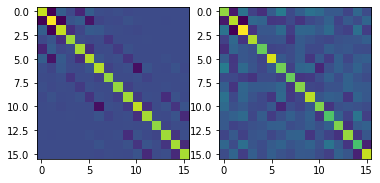

In [38]:
plt.subplot(1,2,1)
plt.imshow(C0)
plt.subplot(1,2,2)
plt.imshow(C)

In [39]:
lamda = 0.05
C1,P1 = skc.graphical_lasso(C,lamda)

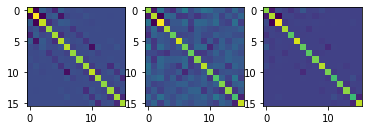

In [40]:
plt.subplot(1,3,1)
plt.imshow(C0)
plt.subplot(1,3,2)
plt.imshow(C)
plt.subplot(1,3,3)
plt.imshow(C1)

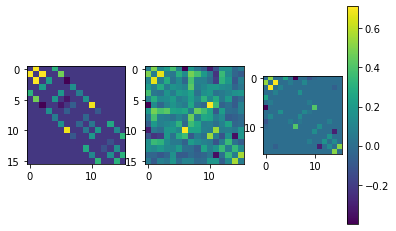

In [41]:
def remove_diag(M):
    return M - np.diag(np.diag(M))
plt.subplot(1,3,1)
plt.imshow(remove_diag(P0))
plt.subplot(1,3,2)
plt.imshow(remove_diag(np.linalg.inv(C)))
plt.subplot(1,3,3)
plt.imshow(remove_diag(P1))
plt.colorbar()

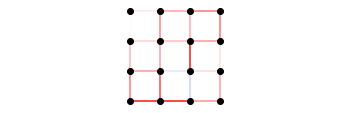

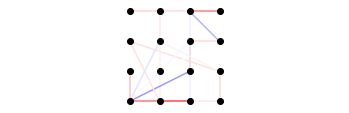

In [42]:
plt.subplot(2,1,1)
gh.dessin_graphe(P0,Vx,Vy)
plt.subplot(2,1,2)
gh.dessin_graphe(P1,Vx,Vy)

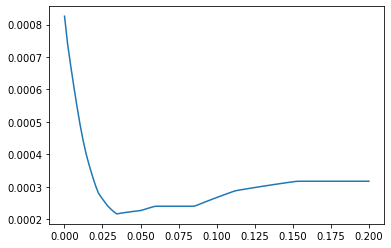

In [43]:
scoreL1 = []
L = list(np.linspace(1e-4,0.2,100))
for lamda in L:
    C1,P1 = skc.graphical_lasso(C,lamda)
    scoreL1.append(np.linalg.norm(P0-P1,1)/n**2)
plt.plot(L,scoreL1)

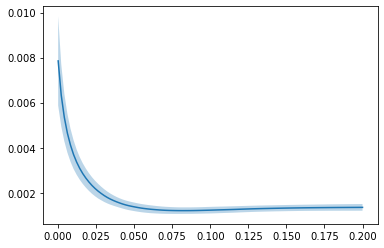

In [47]:
scoreL1 = []
L = list(np.linspace(1e-4,0.2,100))
n = 50 
for i in range(n):
    X = (sc.linalg.sqrtm(C0)@np.random.randn(m,n)).T
    C = X.T@X/n
    score = []
    for lamda in L:
        C1,P1 = skc.graphical_lasso(C,lamda)
        score.append(np.linalg.norm(P0-P1,1)/n**2)
    scoreL1.append(score)

M = np.mean(scoreL1, axis=0)  
S = np.std(scoreL1, axis=0) 
plt.plot(L,M)
plt.fill_between(L,M-S, M+S ,alpha=0.3)

In [50]:
def confusion_result(P0,P1):
    n,p = P0.shape
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(n):
        for j in range(i):
            if P0[i,j]!=0 and P1[i,j]!=0:
                TP +=1
            elif P0[i,j]==0 and P1[i,j]==0:
                FP +=1
            elif P0[i,j]!=0 and P1[i,j]==0:
                TN +=1
            else:
                FN +=1
    return(TP, FP, TN, FN)

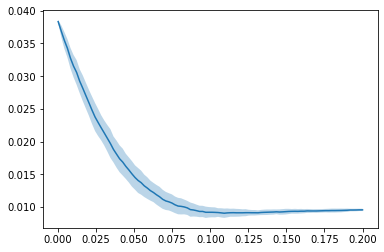

In [52]:
score01 = []
L = list(np.linspace(1e-4,0.2,100))
n = 50 
for i in range(n):
    X = (sc.linalg.sqrtm(C0)@np.random.randn(m,n)).T
    C = X.T@X/n
    score = []
    for lamda in L:
        C1,P1 = skc.graphical_lasso(C,lamda)
        TP, FP, TN, FN = confusion_result(P0,P1) 
        score.append((TN+FN)/n**2)
    score01.append(score)

M = np.mean(score01, axis=0)  
S = np.std(score01, axis=0) 
plt.plot(L,M)
plt.fill_between(L,M-S, M+S ,alpha=0.3)

# A faire



* graphe SBM (stochastic bloc model)

* graphical lasso  : définir autres scores + trouver meilleur lamda et meilleur n pour différents graphes

* graphical lasso avec cvxpt
